# **Hourly averaged concentration prediction of CO in mg/m³**

The chosen dataset contains 9357 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005, columns from 0 to n-1 represents respectively:

---

**0. Date (DD/MM/YYYY)**

**1. Time (HH.MM.SS)**

**2. True hourly averaged concentration CO in mg/m³ (reference analyzer)**

**3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)**

**4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m³ (reference analyzer)**

**5. True hourly averaged Benzene concentration in microg/m³ (reference analyzer)**

**6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)**

**7. True hourly averaged NOx concentration in ppb (reference analyzer)**

**8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)**

**9. True hourly averaged NO2 concentration in microg/m³ (reference analyzer)**

**10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)**

**11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)**

**12. Temperature in °C**

**13. Relative Humidity (%)**

**14. AH Absolute Humidity**

---

In this proyect, I used linear regression using columns [3,14] to predict the values of the second column given any new information about the input compounds, which is useful to prevent or at least make population aware about carbon monoxide posioning and pollution in/outside the most common carbon monoxide sources such as:

* **Vehicle Emissions**
* **Industrial Activites**
* **Combustion Appliances**
* **Tobacco and Wood Burning**

*Not only it has dreadful consequences for the planet but also it could mean imminent death for humans as it's symptoms can be muscle and consciousness disabling.*

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow.estimator import LinearRegressor

In [ ]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

---

For this proyect, 70% of the dataset rows will be used as training data and the other 30% as evaluation data, this distribution has proven to be the finest to obtain the lowest error rate possible.

---

In [ ]:
# Load dataset
data_frame = pd.read_csv('/content/drive/MyDrive/AirQuality.csv', delimiter=";")
# Shuffle dataset
data_frame = data_frame.sample(frac = 1).reset_index(drop=True)
# 70% as training data, 30% as evaluation data
training_features = data_frame.head(n=int((len(data_frame.index) * 0.7)))
evaluation_features =  data_frame.tail(n=int((len(data_frame.index) * 0.3)))
# First and last 2 columns won't be necessary
training_features.pop(training_features.columns[0])
evaluation_features.pop(evaluation_features.columns[0])
training_features.pop(training_features.columns[0])
evaluation_features.pop(evaluation_features.columns[0])
training_features.pop(training_features.columns[14])
evaluation_features.pop(evaluation_features.columns[14])
training_features.pop(training_features.columns[13])
evaluation_features.pop(evaluation_features.columns[13])
# Delete noisy data
training_features.dropna(how="any",inplace = True)
evaluation_features.dropna(how="any",inplace = True)
# Adjusting data types by changing the punctuation type first
training_features["AH"] = training_features["AH"].str.replace(',','.')
training_features["RH"] = training_features["RH"].str.replace(',','.')
training_features["T"] = training_features["T"].str.replace(',','.')
training_features["CO(GT)"] = training_features["CO(GT)"].str.replace(',','.')
training_features["C6H6(GT)"] = training_features["C6H6(GT)"].str.replace(',','.')
training_features["AH"] = training_features["AH"].astype(float)
training_features["RH"] = training_features["RH"].astype(float)
training_features["T"] = training_features["T"].astype(float)
training_features["CO(GT)"] = training_features["CO(GT)"].astype(float)
training_features["C6H6(GT)"] = training_features["C6H6(GT)"].astype(float)

evaluation_features["AH"] = evaluation_features["AH"].str.replace(',','.')
evaluation_features["RH"] = evaluation_features["RH"].str.replace(',','.')
evaluation_features["T"] = evaluation_features["T"].str.replace(',','.')
evaluation_features["CO(GT)"] = evaluation_features["CO(GT)"].str.replace(',','.')
evaluation_features["C6H6(GT)"] = evaluation_features["C6H6(GT)"].str.replace(',','.')
evaluation_features["AH"] = evaluation_features["AH"].astype(float)
evaluation_features["RH"] = evaluation_features["RH"].astype(float)
evaluation_features["T"] = evaluation_features["T"].astype(float)
evaluation_features["CO(GT)"] = evaluation_features["CO(GT)"].astype(float)
evaluation_features["C6H6(GT)"] = evaluation_features["C6H6(GT)"].astype(float)

# -200 equals NA in this dataset
training_features = training_features.loc[training_features["CO(GT)"] != -200]
evaluation_features = evaluation_features.loc[evaluation_features["CO(GT)"] != -200]

# Get training/evaluation labels
training_label = training_features.pop(training_features.columns[0])
evaluation_label = evaluation_features.pop(evaluation_features.columns[0])

# Replace noisy data
training_label = training_label.replace('non_numeric_value', np.nan)
evaluation_label = evaluation_label.replace('non_numeric_value', np.nan)


---

In syntax, the first part of the proyect requires reading the information from the csv and store it as a pandas dataframe, making easier common modifications such as deleting, comparing, shuffling, replacing and converting values, after deleting unrequired columns and making all column datatypes as float, the target column or **"label"** is extracted from the **"features"** dataframe and cleaned as well.

---

## **Linear Regression Overview**

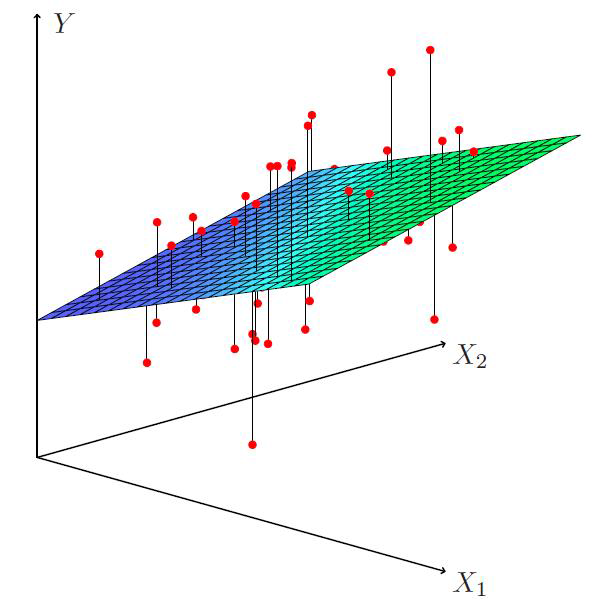

[[Img1 - 3 Dimensional Linear Regression Visualization]](https://medium.com/analytics-vidhya/multiple-linear-regression-an-intuitive-approach-f874f7a6a7f9)

Multivariable linear regression is a statistical modeling technique used to analyze the relationship between multiple independent variables (also known as predictors or features) and a dependent variable (also known as the target variable or response). It extends the concept of simple linear regression, which examines the relationship between a single independent variable and a dependent variable.

In multivariable linear regression, the goal is to fit a linear equation that best predicts the value of the dependent variable based on the values of the independent variables. The equation takes the form:

Y = β0 + β1X1 + β2X2 + ... + βn*Xn + ε

where:

* Y represents the dependent variable
* X1, X2, ..., Xn represent the independent variables
* β0 is the intercept (the value of Y when all independent variables are zero)
* β1, β2, ..., βn are the coefficients that represent the effect of each independent variable on the dependent variable
* ε is the error term, representing the variability that cannot be explained by the independent variables

The coefficients (β1, β2, ..., βn) are estimated using a method called ordinary least squares (OLS), which minimizes the sum of squared differences between the predicted values and the actual values of the dependent variable. The OLS method finds the best-fitting line that minimizes the overall error.

In [ ]:
# Thanks to the previous convertion, all columns of the dataset are numerical and won't need hot encoding
NUMERIC_COLUMNS = ['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

feature_columns = []
# Adding the already numeric columns to the feature columns
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Batching function definition needed for the model, default number of epochs and batches were chosen based on evaluation error rate
def make_input_fn(data_df, label_df, num_epochs=300, shuffle=True, batch_size=64):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

# Making the batches for training data
train_input_fn = make_input_fn(training_features, training_label)
# Making the batches for evaluation data
eval_input_fn = make_input_fn(evaluation_features, evaluation_label, num_epochs=1, shuffle=False)

---

**Epochs** refers to the number of times the model is gonna read the data and readjust the equation created at the first epoch in order to get the less error ratio possible, normally, this can be explained as an open downward parabolic function where very few epochs won't be enough learning opportunities for the model while a lot of epochs lands on **overfitting**:

---

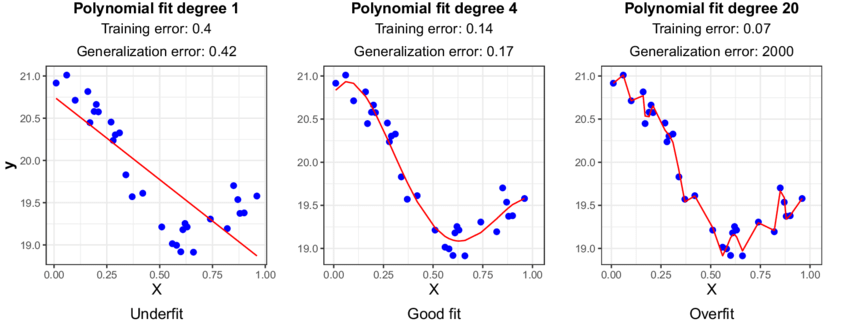

[[Img2 - Overfitting Linear Regression Visualization]](https://www.researchgate.net/figure/llustration-of-the-underfitting-overfitting-issue-on-a-simple-regression-case-Data_fig2_339680577)

---

**Batching** is the process of dividing the dataset into *number_of_rows / batch_size* sub-datasets in order to not overload the RAM with immense amount of information being readed at the same time, it actually has an impact on the final results so the *batch_size* also needs to be modified during the testing process:

---

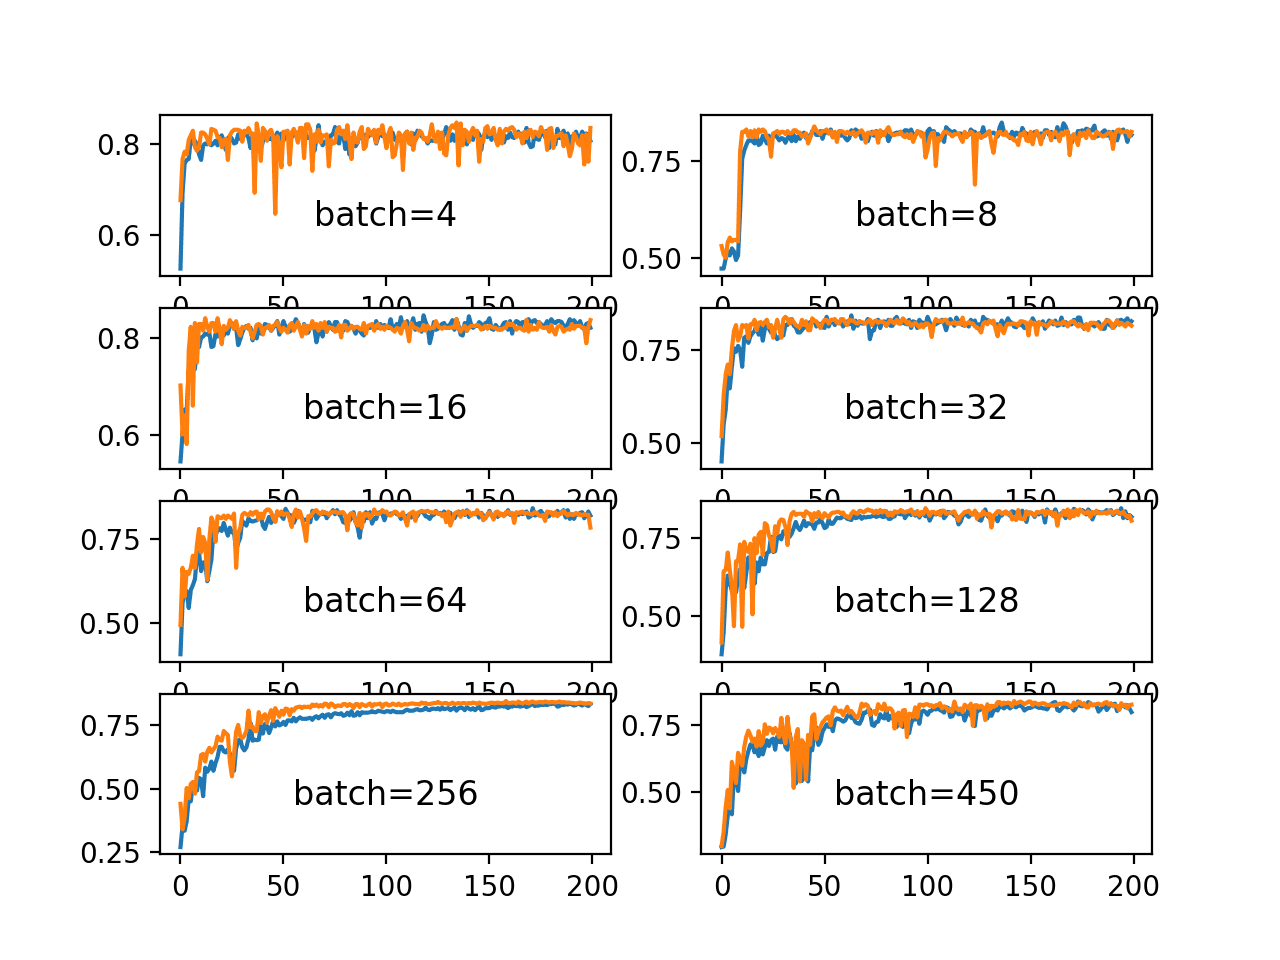

[[Img3 - Batching Results Visualization]](https://www.google.com/search?q=batching+machine+learning&rlz=1C1CAFC_enCR933CR933&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjz1OCjnq3_AhUQTTABHfc7B24Q_AUoAXoECAEQAw&biw=1366&bih=649&dpr=1#imgrc=pCfHcAkRPaZW4M)

---

In [ ]:
#print(evaluation_features.dtypes)

In [ ]:
# Creating the LinearRegressor model
linear_est = LinearRegressor(feature_columns=feature_columns)
# Training process
linear_est.train(train_input_fn)
# Evaluation process
result = linear_est.evaluate(eval_input_fn)

In [ ]:
#result

In [ ]:
predictions = list(linear_est.predict(eval_input_fn))
#print(evaluation_label.iloc[863])
#print(predictions[863])

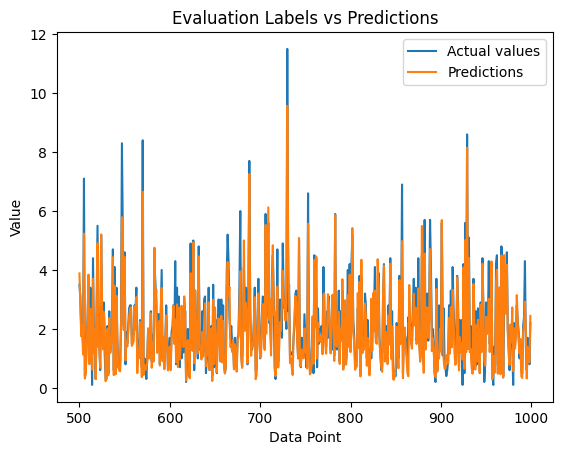

In [ ]:
# Extract numeric values from the predictions
prediction_values = [pred['predictions'][0] for pred in predictions]

# Convert the evaluation label to a list
evaluation_label_list = list(evaluation_label)

start = 500
end = 1000

# Generate x-axis values from start to end
x_values = range(start, end)

# Plot the evaluation labels
plt.plot(x_values, evaluation_label_list[start:end], label='Actual values')

# Plot the predictions
plt.plot(x_values, prediction_values[start:end], label='Predictions')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Evaluation Labels vs Predictions')

# Add legend
plt.legend()

# Show the plot
plt.show()